# Automatic License Plate Recognition

**Importing the necessary libraries**

In [ ]:
import shutil
from pathlib import Path
import pandas as pd
import pytesseract
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

**Installing Tesseract OCR**

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

**Cloning the github repo of YOLOv5**

In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.8/78.2 GB disk)


The annotations were initially in the format:
<br>
<br>
camera: GoPro Hero4 Silver <br>
position_vehicle: 763 329 250 232 <ul type = "none">
	type: car <br>
	make: Ford <br>
	model: EcoSport <br>
	year: 2013 <br>
</ul>
plate: MLS-5511 <br>
position_plate: 855 504 64 21 <ul type = "none">
	char 1: 859 510 7 12 <br>
	char 2: 867 510 7 12 <br>
	char 3: 874 511 7 11 <br>
	char 4: 885 511 7 11 <br>
	char 5: 893 511 7 11 <br>
	char 6: 902 511 3 12 <br>
	char 7: 910 511 3 11 <br>
</ul>
<br>
<br>

Converting it to YOLO acceptable format while keeping the position of license plate only:
<br>
<br>

0 0.4934895833333333 0.49953703703703706 0.03802083333333333 0.026851851851851852

In [ ]:
a = list(Path("UFPR-ALPR dataset/validation/").glob("**/*.txt"))

for i in a:
    shutil.copy(i,'annos/')

b = list(Path("annos/").glob("*.txt"))

main = []
for i in b:
    with open(i) as f:
        content = f.read()
        alpha = (list(map(int,content[(content.index('position_plate')+15):(content.index('char 1')-2)].strip().split(" "))))
        alpha.append(str(i)[6:])
        main.append(alpha)
        
for i in range(len(main)):
    main[i][0] = (main[i][0]+(main[i][2])/2)/1920
    main[i][1] = (main[i][1]+(main[i][3])/2)/1080
    main[i][2] = (main[i][2])/1920
    main[i][3] = (main[i][3])/1080
    
for i in main:
    i.insert(0,0)
    
df = pd.DataFrame(main, columns=['object-class', 'x_center', 'y_center', 'width', 'height', 'filename'])

for i, row in df.iterrows():
    # Extract the values for each row
    obj_class = row['object-class']
    x_center = row['x_center']
    y_center = row['y_center']
    width = row['width']
    height = row['height']
    filename = row['filename']
    
    # Create the YOLO annotation line
    yolo_line = f"{obj_class} {x_center} {y_center} {width} {height}"
    
    # Write the YOLO annotation line to a text file with the same name as the image file
    with open(f"labels/{filename}", "w") as f:
        f.write(yolo_line)

After the above cell, <br>
Created a custom.yaml file which contained:<br>
<br>
train: /content/drive/MyDrive/ACNR/final_dataset/train<br>
val: /content/drive/MyDrive/ACNR/final_dataset/val<br>
<br>
nc: 1<br>
names: ['LP']<br>
<br>
Uploaded the data and custom.yaml file to drive and used colab to do the training part<br>

##Training the YOLOv5s6 model over the data

In [ ]:
!python train.py --img 640 --batch -1 --epochs 100 --data /content/drive/MyDrive/ACNR/final_dataset/custom.yaml --weights yolov5s6.pt --cache

train: weights=yolov5s6.pt, cfg=, data=/content/drive/MyDrive/ACNR/final_dataset/custom.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-114-g3c0a6e6 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gam

Performing inference using the trained weights over a new image

In [5]:
!python detect.py --save-crop --weights "/content/drive/MyDrive/ALPR/yolov5s6.pt" --img 640 --conf 0.25 --source "/content/drive/MyDrive/ALPR/range-rover-2022-001-tracking-front.jpg"

detect: weights=['/content/drive/MyDrive/ALPR/yolov5s6.pt'], source=/content/drive/MyDrive/ALPR/range-rover-2022-001-tracking-front.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 206 layers, 12308200 parameters, 0 gradients, 16.1 GFLOPs
image 1/1 /content/drive/MyDrive/ALPR/range-rover-2022-001-tracking-front.jpg: 448x640 1 LP, 24.2ms
Speed: 0.7ms pre-process, 24.2ms inference, 50.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


Detected License plate in the inference image

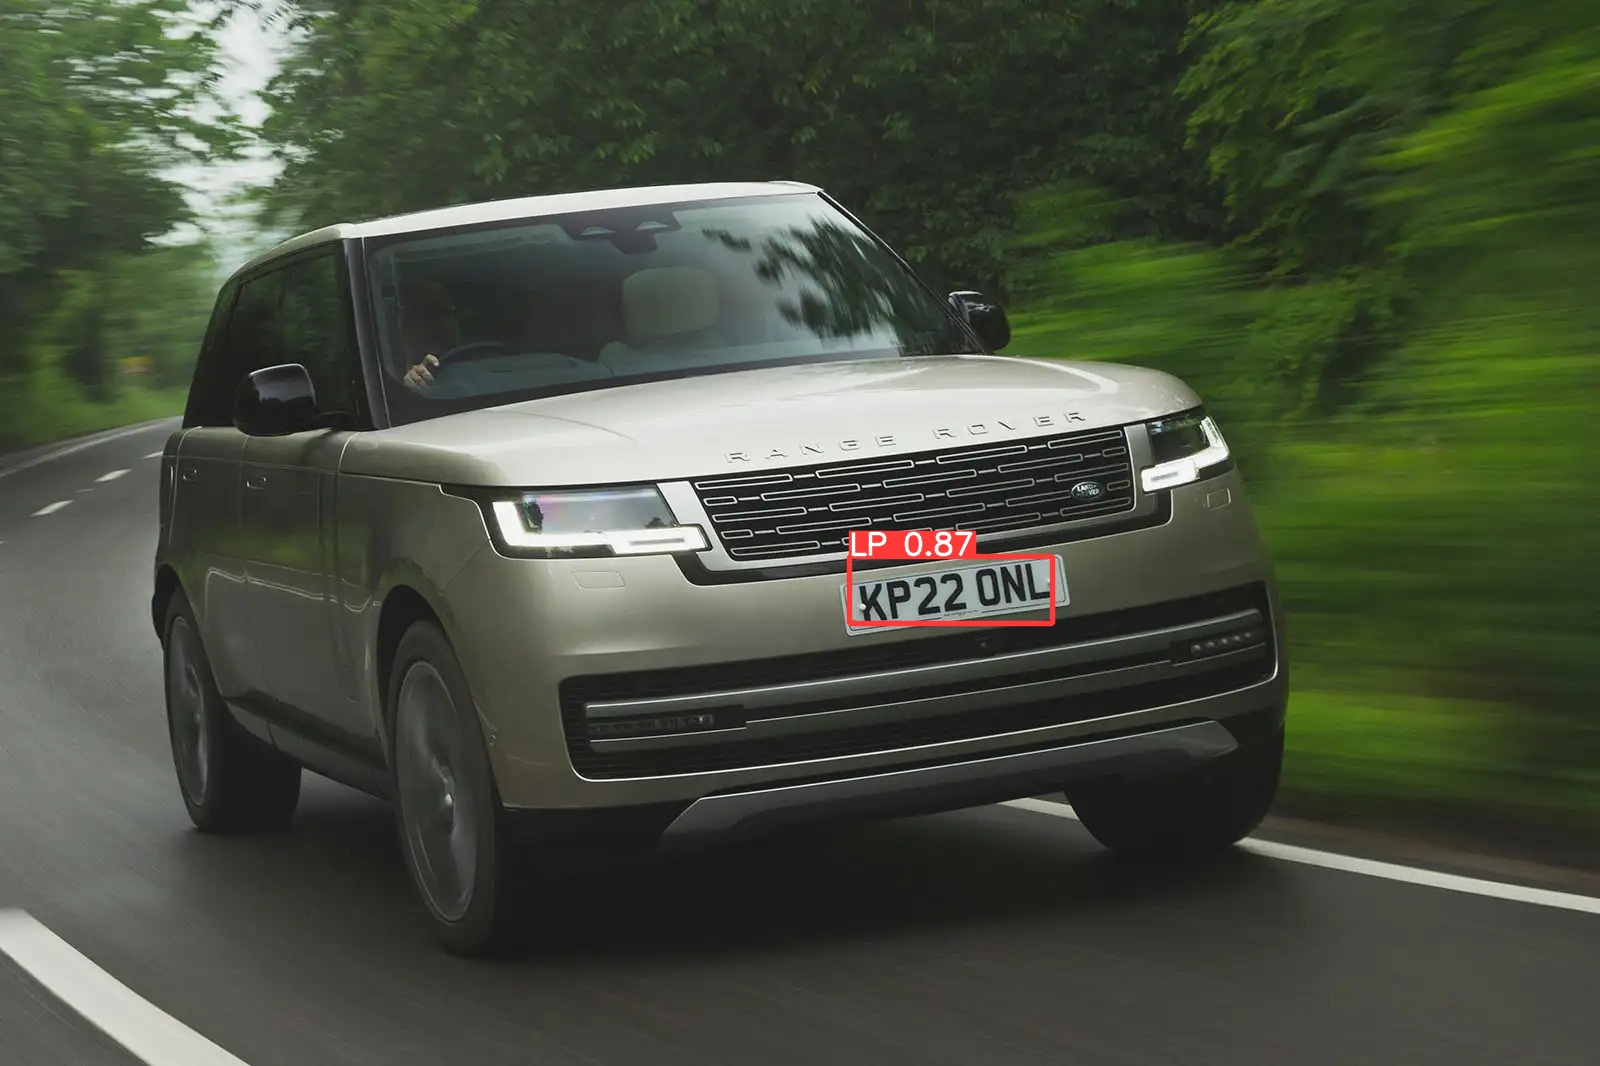

Cropped Image of License plate

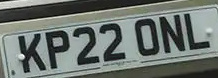

Running the cropped image through pytesseract to get License plate number

In [ ]:
image_path_in_colab='/content/yolov5/runs/detect/exp/crops/LP/range-rover-2022-001-tracking-front.jpg'
extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))

In [2]:
print(extractedInformation.upper())

KP22ONL


###Got the correct license plate number as we can see in the localized and the cropped image